In [1]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn import metrics
from statsmodels.tsa.stattools import pacf, acf
import statsmodels.api as sm
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
forecasts = {}
test_errors = {}

In [3]:
data = pd.read_csv("PJME_hourly.csv", parse_dates=['Datetime']).sort_values(by = "Datetime")

def split_data(data, split_date):
    return data[data['Datetime'] <= split_date].copy(), \
           data[data['Datetime'] >  split_date].copy()

def limit(data, frm, to):
    return data[(data['Datetime']>=frm)&(data['Datetime']<to)]

train, test = split_data(data, '01-Jul-2002')

train = limit(data, '03-01-2011', '04-01-2011')
test  = limit(data, '04-01-2011', '05-01-2011')

In [5]:
df = pd.concat([train, test])


In [10]:
df.to_csv('PJME.csv', index = False)

In [5]:
df['hour'] = df['Datetime'].dt.hour
df['day_of_month'] = df['Datetime'].dt.days_in_month
df['day_of_week'] = df['Datetime'].dt.day_of_week

<Axes: xlabel='Datetime'>

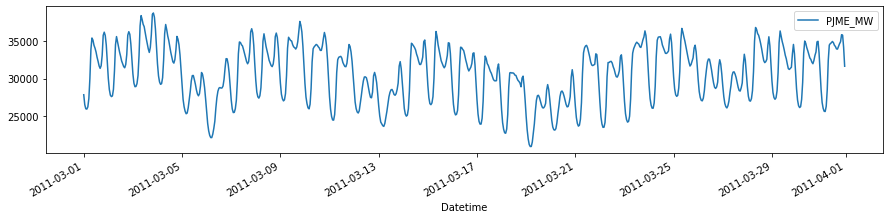

In [6]:
df[:len(train)].plot(y='PJME_MW', x='Datetime', figsize = (15, 3))

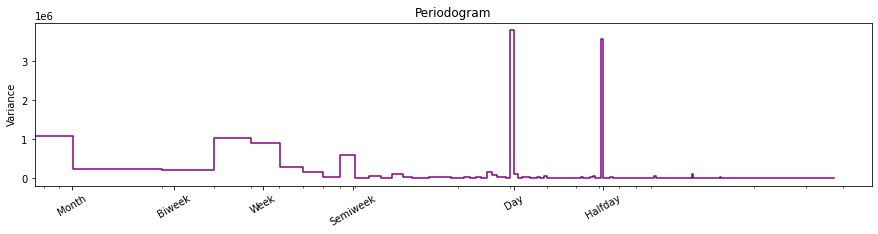

In [7]:
freqencies, spectrum = periodogram(
        df[:len(train)]['PJME_MW'],
        fs=744,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )

plt.figure(figsize=(15, 3))
plt.step(freqencies, spectrum, color="purple")
plt.xscale("log")
plt.xticks([1, 2.2, 4.4, 8.85, 31, 62],
          [
        "Month",
        "Biweek",
        "Week",
        "Semiweek",
        "Day",
        "Halfday"
    ],rotation=30)
plt.ylabel("Variance")
plt.title("Periodogram")
plt.show()

In [8]:
dates = df['Datetime'].unique()
hours = np.arange(1, len(dates)+1)
hours = pd.DataFrame({"Datetime":dates, "Hour_tick":hours})
df = df.merge(hours, on="Datetime", how="left")

In [9]:
Seasonality = dict(zip(
    (12, 24, 84, 168, 744),
    ('Halfday', 'Day', 'Semiweek', 'Week')
))

for s, n in Seasonality.items():
    df[f'sin_{n}'] = np.sin(df['Hour_tick'] * (2*np.pi / s))
    df[f'cos_{n}'] = np.cos(df['Hour_tick'] * (2*np.pi / s))

## XGBoost w/o lag

In [10]:
X_train = df[:len(train)].set_index('Datetime').drop(columns = ['PJME_MW'])
y_train = df[:len(train)].set_index('Datetime')['PJME_MW']

X_test = df[len(train):].set_index('Datetime').drop(columns = ['PJME_MW'])

model = XGBRegressor()
model.fit(X_train, y_train)

training_error = metrics.mean_absolute_percentage_error(y_train, model.predict(X_train))

In [11]:
forecasts["XGBoost_wo_lag"] = pd.Series(model.predict(X_test), index = X_test.index)
test_errors["XGBoost_wo_lag"] = metrics.mean_absolute_percentage_error(test['PJME_MW'], forecasts["XGBoost_wo_lag"])

print("Training error: ", training_error)
print("Test error: ", test_errors['XGBoost_wo_lag'])

Training error:  0.0007543775156238162
Test error:  0.1149504862399257


## XGBoost

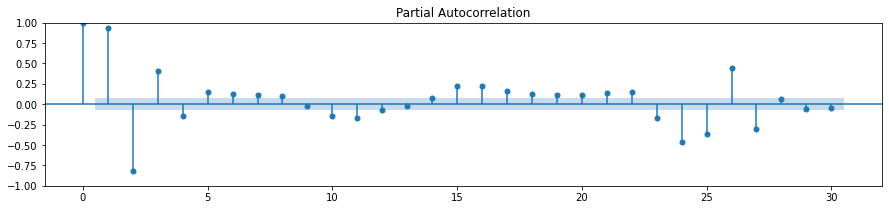

In [12]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
plot_pacf(df[:len(train)]['PJME_MW'], lags=30, ax=ax)
plt.show()

In [13]:
alpha=0.05
method="ywm"
nlags = len(df[:len(train)]['PJME_MW'])//2-1

lags, thresh = pacf(df[:len(train)]['PJME_MW'], nlags=nlags, alpha=alpha, method=method)

lags = np.where((lags/2 > thresh[:, 1] - lags) | (lags/2 < thresh[:, 0] - lags))[0][1:]
lags

array([  1,   2,   3,   4,   5,  11,  15,  16,  17,  22,  23,  24,  25,
        26,  27, 144])

In [14]:
for lag in lags:                                                                                                                          
    df[f'lag_{lag}'] = df['PJME_MW'].shift(lag)

In [15]:
nan_head = df[df['Datetime'] == df['Datetime'][0] + pd.Timedelta(lags[-1], "H")].index[0]
df = df[nan_head:].set_index('Datetime')

In [16]:
X_train = df.dropna().drop(columns = ['PJME_MW'])
y_train = df.dropna()['PJME_MW']

model = XGBRegressor()
model.fit(X_train, y_train)

training_error = metrics.mean_absolute_percentage_error(y_train, model.predict(X_train))

In [17]:
forecast = df.copy()

forecast_date_range = forecast[forecast['PJME_MW'].isna()].index

for i in (range(len(forecast[forecast['PJME_MW'].isna()].index))):
    
    future_index = forecast[forecast['PJME_MW'].isna()].index[0]
    future_X = forecast.loc[future_index:future_index].drop(columns = ['PJME_MW'])

    future_1 = model.predict(future_X)[0]

    try:
        forecast.loc[future_index, 'PJME_MW'] = future_1
        for lag in lags:
            forecast.loc[future_index + pd.Timedelta(lag, "H"), f'lag_{lag}'] = future_1

    except Exception as e:
        pass

forecast = forecast.loc[forecast_date_range[0]:forecast_date_range[-1]]
test_error = metrics.mean_absolute_percentage_error(test['PJME_MW'], forecast['PJME_MW'])

print("Training error: ", training_error)
print("Test error: ", test_error)

Training error:  0.00014749160517012758
Test error:  0.10883410258711403


In [18]:
forecasts["XGBoost"] = forecast['PJME_MW']
test_errors["XGBoost"] = test_error

## Hessan Ridge

In [19]:
X_train = df.dropna().drop(columns = ['PJME_MW'])
y_train = df.dropna()['PJME_MW']

model_R = Ridge()
model_R.fit(X_train, y_train)

training_error_R = metrics.mean_absolute_percentage_error(y_train, model_R.predict(X_train))

In [20]:
forecast_R = df.copy()

forecast_date_range = forecast_R[forecast_R['PJME_MW'].isna()].index

for i in (range(len(forecast_R[forecast_R['PJME_MW'].isna()].index))):

    future_index = forecast_R[forecast_R['PJME_MW'].isna()].index[0]
    future_X = forecast_R.loc[future_index:future_index].drop(columns = ['PJME_MW'])

    future_1 = model_R.predict(future_X)[0]

    try:
        forecast_R.loc[future_index, 'PJME_MW'] = future_1
        for lag in lags:
            forecast_R.loc[future_index + pd.Timedelta(lag, "H"), f'lag_{lag}'] = future_1

    except Exception as e:
        pass

forecast_R = forecast_R.loc[forecast_date_range[0]:forecast_date_range[-1]]
test_error_R = metrics.mean_absolute_percentage_error(test['PJME_MW'], forecast_R['PJME_MW'])

print("Training error: ", training_error_R)
print("Test error: ", test_error_R)

Training error:  0.007116860676215928
Test error:  0.0817125303223552


In [21]:
forecasts["Ridge"] = forecast_R['PJME_MW']
test_errors["Ridge"] = test_error_R

## Arima

In [22]:
model_A = sm.tsa.statespace.SARIMAX(train.set_index("Datetime"),
                                order=(1,1,1),
                                seasonal_order=(0,0,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_A = model_A.fit()

forecast_A = results_A.forecast(steps=test.shape[0])
forecast_A.index = test['Datetime']
test_error_A = metrics.mean_absolute_percentage_error(test['PJME_MW'], forecast_A)
print("Test error: ", test_error_A)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83932D+00    |proj g|=  7.55714D-02


/home/sesh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sesh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



At iterate    5    f=  7.83659D+00    |proj g|=  1.39406D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     10      1     0     0   1.394D-04   7.837D+00
  F =   7.8365899014163158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Test error:  0.12768397052361358


/home/sesh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [23]:
forecasts["Sarimax"] = forecast_A
test_errors["Sarimax"] = test_error_A

## Prophet

In [24]:
model_P = Prophet(interval_width=0.95)
model_P.fit(pd.DataFrame({'ds': train['Datetime'], 'y':train['PJME_MW']}))
future_dates = model_P.make_future_dataframe(periods=test.shape[0], freq='H')
results_P = model_P.predict(future_dates[train.shape[0]:])
forecast_P = results_P.set_index('ds')['yhat']

test_error_P = metrics.mean_absolute_percentage_error(test['PJME_MW'], forecast_P)
print("Test error: ", test_error_P)

14:00:36 - cmdstanpy - INFO - Chain [1] start processing
14:00:36 - cmdstanpy - INFO - Chain [1] done processing


Test error:  0.07047979231978731


In [25]:
forecasts["Prophet"] = forecast_P
test_errors["Prophet"] = test_error_P

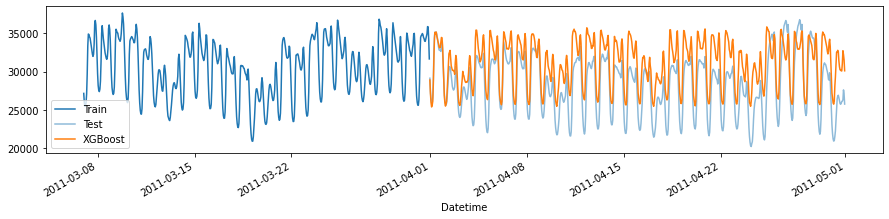

In [29]:
ax = df.loc["03-01-2011":]['PJME_MW'].plot(figsize = (15, 3), label='Train')
test.plot(x = 'Datetime', y = 'PJME_MW', ax = ax, c = 'tab:blue', alpha = 0.5, label = 'Test')

forecasts['XGBoost'].plot(ax = ax, label = 'XGBoost')

ax.legend()

In [27]:
pd.DataFrame(test_errors, index=['Test score']).T

,Test score
XGBoost_wo_lag,0.114950
XGBoost,0.108834
Ridge,0.081713
Sarimax,0.127684
Prophet,0.070480
